In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import pathlib
import PIL
from tensorflow.keras.layers import *
import random

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
TRAIN_PATH = "../input/vggface-using-tripletloss/crop_faces/faces"
HEIGHT,WIDTH = 64,64
CHANNELS = 3
NUM_CLASSES = len(os.listdir(TRAIN_PATH))

TOT_IMG = 0
for i in os.listdir(TRAIN_PATH):
    TOT_IMG+=len(os.listdir(os.path.join(TRAIN_PATH,i)))
    
SPLIT = int(0.9*TOT_IMG)
BATCH_SIZE = 32
MONITOR = "val_loss"

def filepath_to_arr(filepath,SHAPE = (HEIGHT,WIDTH)):
    img = tf.keras.preprocessing.image.load_img(filepath,target_size=SHAPE)
    arr = tf.keras.preprocessing.image.img_to_array(img)/255.
    return arr

def train_data(path_ls):
    tot_img = TOT_IMG
    label_arr = np.zeros((tot_img,))
    img_arr = np.zeros((tot_img,HEIGHT,WIDTH,3))
    
    for i,path in enumerate(path_ls):
        label_arr[i] = label_dir[path.split("/")[-2]]
        img_arr[i] = filepath_to_arr(path)
    return img_arr,label_arr

In [3]:
label_dir = {}
path_ls = []
for i,folder in enumerate(os.listdir(TRAIN_PATH)):
    label_dir[folder] = i+1
    dir_path = os.path.join(TRAIN_PATH,folder)
    for img in os.listdir(dir_path):
        path_ls.append(os.path.join(dir_path,img))
        
random.seed(143)        
random.shuffle(path_ls)

img_arr,label_arr = train_data(path_ls)

train_arr ,train_label = img_arr[:SPLIT],label_arr[:SPLIT]
val_arr , val_label = img_arr[SPLIT:],label_arr[SPLIT:]

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((train_arr ,train_label))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_arr , val_label))
val_ds = val_ds.shuffle(1000).batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
class NormalizeLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(NormalizeLayer, self).__init__()
    def call(self, inputs, mask=None):
        return tf.math.l2_normalize(inputs, axis=-1)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}
    
norm_layer = NormalizeLayer()

vgg16= tf.keras.applications.VGG16(weights = 'imagenet',include_top = False,input_shape = (HEIGHT,WIDTH, 3),pooling = "avg")
for layer in vgg16.layers:
        name = layer.name
        if name.split("_")[0] == "block5":
            layer.trainable = True
        else:
            layer.trainable = False
  
    
def create_model():
    top_model = vgg16.output
    top_model = tf.keras.layers.Dropout(0.3) (top_model)
    top_model = tf.keras.layers.Dense(128,activation="softmax")(top_model)
    top_model = norm_layer(top_model)
        
    model = tf.keras.Model(inputs = vgg16.input, outputs = top_model)
    
    return model

model = create_model()
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [5]:
def pairwise_distances(embeddings):
    dot_product = tf.linalg.matmul(embeddings, tf.transpose(embeddings))
    square_norm = tf.linalg.diag_part(dot_product)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)
    distances = tf.math.maximum(distances, 0.0)

    mask = tf.cast(tf.equal(distances, 0.0),tf.float32)
    distances = distances + mask * 1e-16
    distances = tf.math.sqrt(distances)
    distances = distances * (1.0 - mask)

    return distances

def get_anchor_positive_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.math.logical_not(indices_equal)

    labels_equal = tf.math.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.math.logical_and(indices_not_equal, labels_equal)

    return mask

def get_anchor_negative_triplet_mask(labels):
    labels_equal = tf.math.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.math.logical_not(labels_equal)

    return mask

def get_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.math.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.math.logical_and(tf.math.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    label_equal = tf.math.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.math.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    mask = tf.math.logical_and(distinct_indices, valid_labels)

    return mask


class TripletLossFn(tf.keras.losses.Loss):
    def __init__(self,margin=1.0,**kwargs):
        super().__init__(**kwargs)
        self.margin = margin
  
    def call(self,y_true,y_pred):

        labels = tf.convert_to_tensor(y_true)
        labels = tf.squeeze(labels,axis=-1)
        embeddings = tf.convert_to_tensor(y_pred)

        pairwise_dist = pairwise_distances(embeddings)

        mask_anchor_positive = get_anchor_positive_triplet_mask(labels)
        mask_anchor_positive = tf.cast(mask_anchor_positive,tf.float32)

        anchor_positive_dist = tf.math.multiply(mask_anchor_positive, pairwise_dist)

        hardest_positive_dist = tf.math.reduce_max(anchor_positive_dist, axis=1, keepdims=True)


        mask_anchor_negative = get_anchor_negative_triplet_mask(labels)
        mask_anchor_negative = tf.cast(mask_anchor_negative,tf.float32)

        max_anchor_negative_dist = tf.math.reduce_max(pairwise_dist, axis=1, keepdims=True)
        anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)


        hardest_negative_dist = tf.math.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    

        triplet_loss = tf.math.maximum(hardest_positive_dist - hardest_negative_dist + self.margin, 0.0)

        triplet_loss = tf.math.reduce_mean(triplet_loss)

        return triplet_loss
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,"margin":self.margin}

In [6]:
def create_callbacks(model_save_path,monitor=MONITOR):
    
    
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    
    cpk_path = f'{model_save_path}/best_model.h5'

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor=monitor,
        mode="min",
        save_best_only=True,
        verbose=1
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= monitor,     
        mode="min",
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,       
        mode="min",
        patience=15, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]       
    
    return callbacks

In [7]:
def compile_model(model, lr=0.0001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    loss = TripletLossFn(0.3)
    model.compile(optimizer=optimizer, loss=loss)
    
    return model

In [8]:
EPOCHS = 100
VERBOSE  = 1
MODEL_PATH = '.'

with tf.device("/device:GPU:0"):
    model = create_model()
    
    model = compile_model(model, lr=0.00001)
   
    callbacks = create_callbacks(MODEL_PATH)
    
    history = model.fit(train_ds, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE)

Epoch 1/100
104/104 [==============================] - 6s 24ms/step - loss: 0.1802 - val_loss: 0.1499

Epoch 00001: val_loss improved from inf to 0.14988, saving model to ./best_model.h5
Epoch 2/100
104/104 [==============================] - 2s 15ms/step - loss: 0.1621 - val_loss: 0.1479

Epoch 00002: val_loss improved from 0.14988 to 0.14786, saving model to ./best_model.h5
Epoch 3/100
104/104 [==============================] - 2s 15ms/step - loss: 0.1488 - val_loss: 0.1480

Epoch 00003: val_loss did not improve from 0.14786
Epoch 4/100
104/104 [==============================] - 2s 15ms/step - loss: 0.1412 - val_loss: 0.1504

Epoch 00004: val_loss did not improve from 0.14786
Epoch 5/100
104/104 [==============================] - 2s 15ms/step - loss: 0.1303 - val_loss: 0.1591

Epoch 00005: val_loss did not improve from 0.14786
Epoch 6/100
104/104 [==============================] - 2s 15ms/step - loss: 0.1227 - val_loss: 0.1580

Epoch 00006: val_loss did not improve from 0.14786
Epoch 

In [9]:
best_model = tf.keras.models.load_model("./best_model.h5",custom_objects={"TripletLossFn":TripletLossFn,"NormalizeLayer":NormalizeLayer})
embed = best_model.predict(train_arr[:])

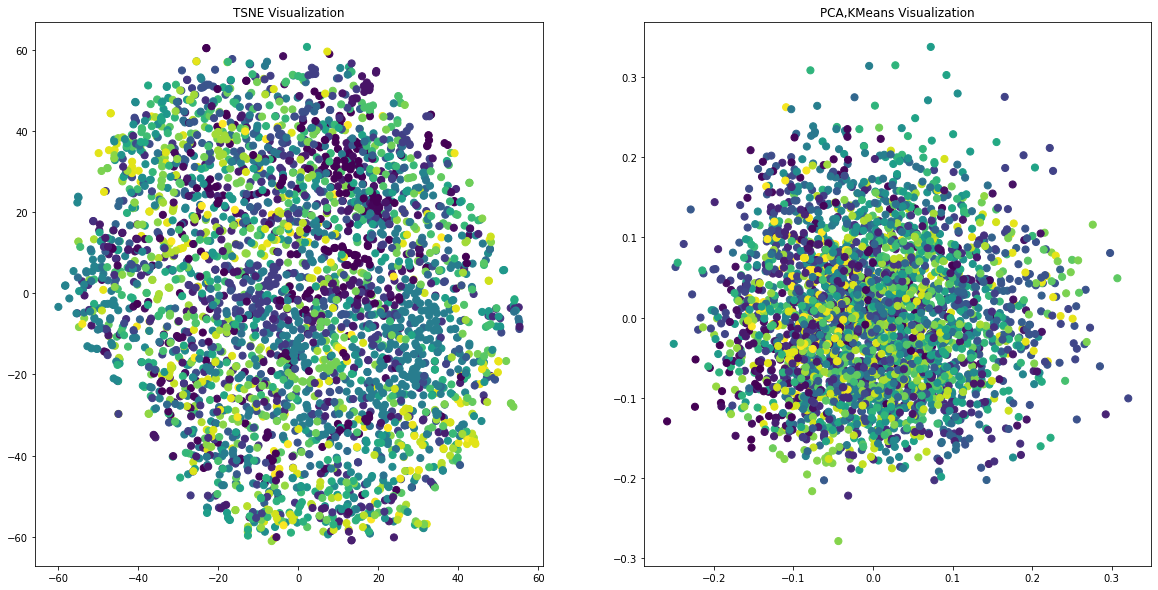

In [10]:
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(embed)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("TSNE Visualization")
plt.scatter(reduced[:,0],reduced[:,1], c=train_label[:], s=50, cmap='viridis')

pca = PCA(2)
embed_2 = pca.fit_transform(embed)
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0)
labels = kmeans.fit_predict(embed)

plt.subplot(1,2,2)
plt.title("PCA,KMeans Visualization")
plt.scatter(embed_2[:, 0], embed_2[:, 1], c=labels, s=50, cmap='viridis')
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.show()

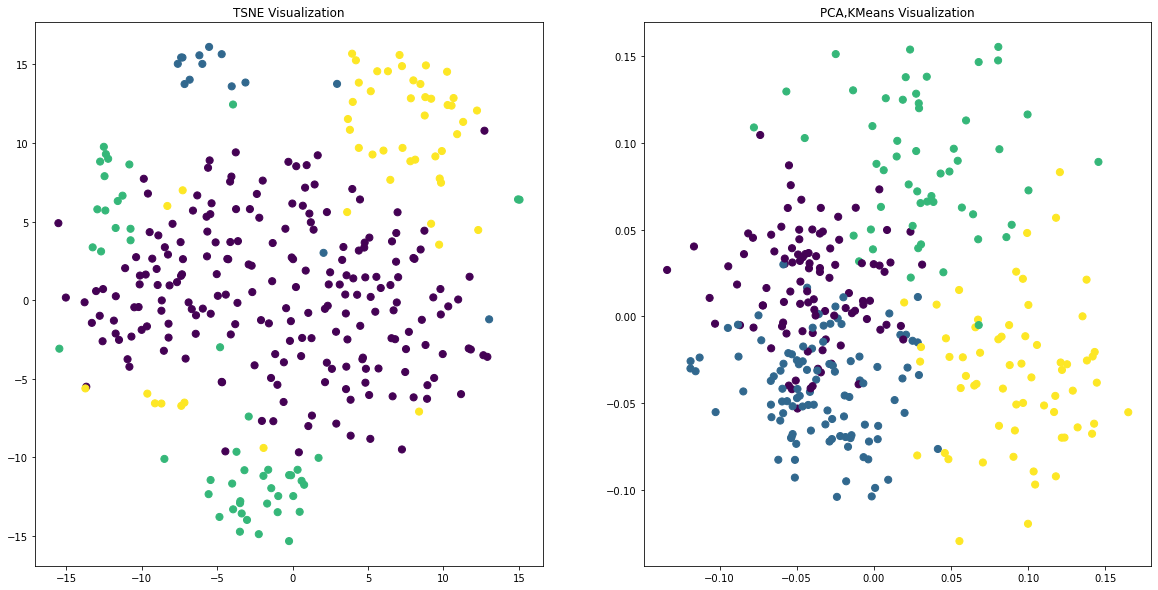

In [11]:
ls = [1,2,3,4]
count = 0
NUM = 0

for i,label in enumerate(label_arr):
    if label in ls:
        NUM+=1

test_arr= np.zeros((NUM,HEIGHT,WIDTH,3))
test_labels = np.zeros((NUM,))

for i,label in enumerate(label_arr):
    if label in ls:
        test_labels[count] = label
        test_arr[count] = img_arr[i]
        count+=1
        
embed = model.predict(test_arr)

tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(embed)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("TSNE Visualization")
plt.scatter(reduced[:,0],reduced[:,1], c=test_labels, s=50, cmap='viridis')

pca = PCA(2)
embed_2 = pca.fit_transform(embed)
kmeans = KMeans(n_clusters=len(ls), random_state=0)
labels = kmeans.fit_predict(embed)

plt.subplot(1,2,2)
plt.title("PCA,KMeans Visualization")
plt.scatter(embed_2[:, 0], embed_2[:, 1], c=labels, s=50, cmap='viridis')
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.show()